In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
import numpy as np
import pingouin as pg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

import seaborn as sns

LOAD THE DATA

In [2]:
data = pd.read_csv('train.csv')

SEE DISTRIBUTION OF PASSENGER_COUNT

Median Passenger Count: 1.0


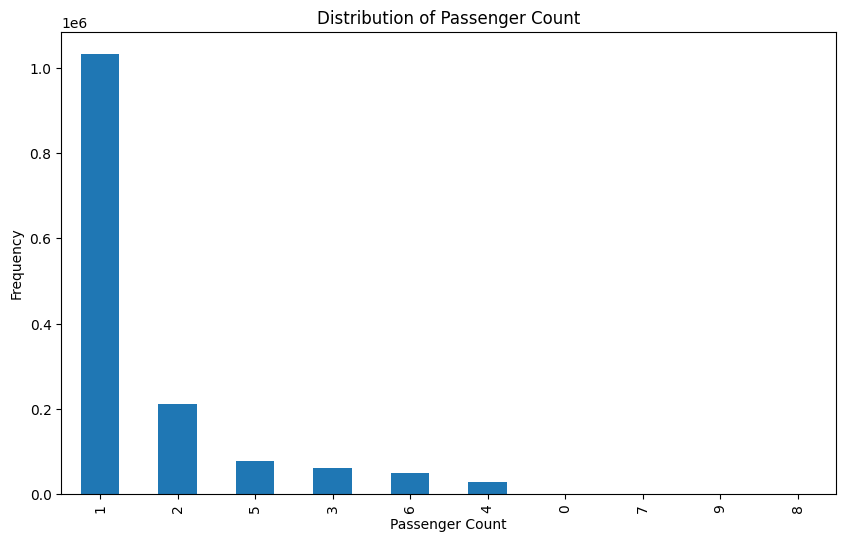

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
median_passenger_count = data['passenger_count'].median()
print(f"Median Passenger Count: {median_passenger_count}")
data['passenger_count'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Distribution of Passenger Count')
ax.set_xlabel('Passenger Count')
ax.set_ylabel('Frequency')
plt.show()

We can see that the majority of amount of passenger is 1

Isn't it usual to passenger_count larger than > 6 and is 0? i dont think so. We're going to drop em off

In [4]:
data = data[(data['passenger_count'] <= 6) & (data['passenger_count'] > 0)]

Then we want to see the distribution of trip_duration

{'whiskers': [<matplotlib.lines.Line2D at 0x22e059e9d90>,
 'caps': [<matplotlib.lines.Line2D at 0x22e059eb650>,
 'boxes': [<matplotlib.lines.Line2D at 0x22e059e9150>],
 'medians': [<matplotlib.lines.Line2D at 0x22e059f8d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x22e059f9910>],
 'means': []}

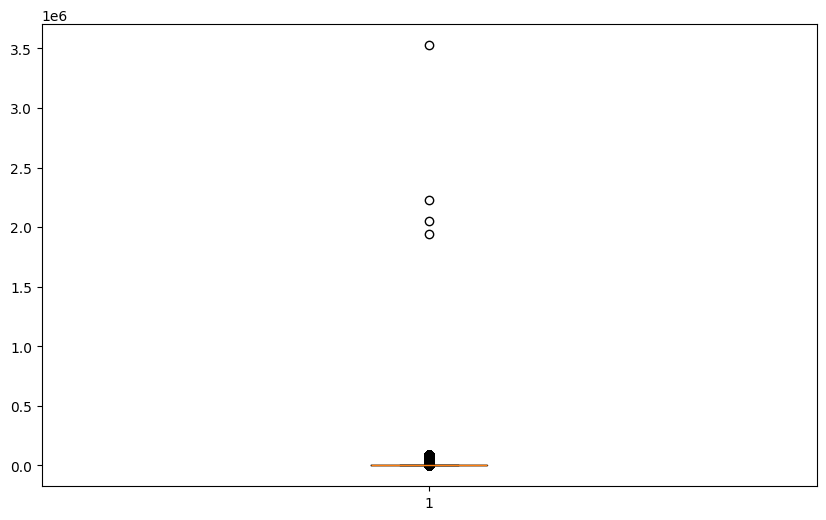

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(data["trip_duration"])

Whoaaa that's a lot of outlier isn't it?

Then we have to remove da outlier using the Interquartil Range method !

In [6]:
Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['trip_duration'] >= lower_bound) & (data['trip_duration'] <= upper_bound)]

count    1.384363e+06
mean     7.317274e+02
std      4.480947e+02
min      1.000000e+00
25%      3.850000e+02
50%      6.320000e+02
75%      9.910000e+02
max      2.092000e+03
Name: trip_duration, dtype: float64


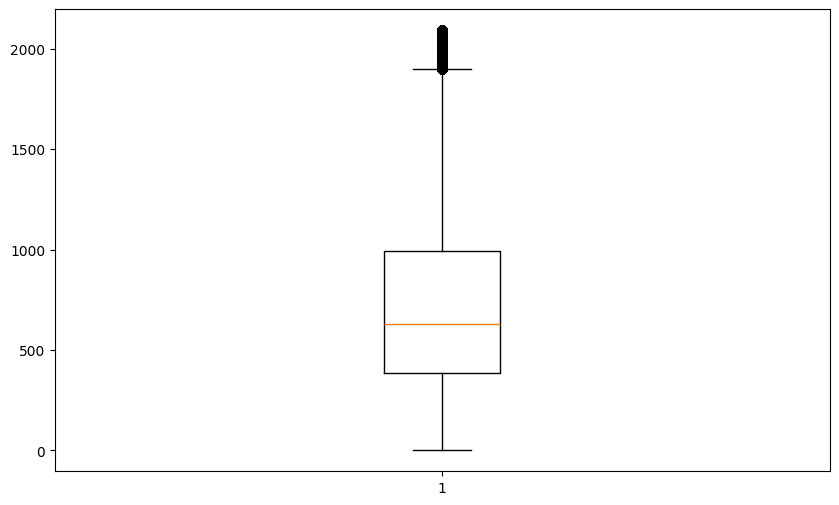

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(data["trip_duration"])
print(data["trip_duration"].describe())

That's better isn't it?

We also want to know if there's any correlation between pickup_day and trip_duration

In [8]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_day'] = data['pickup_datetime'].dt.day_name()

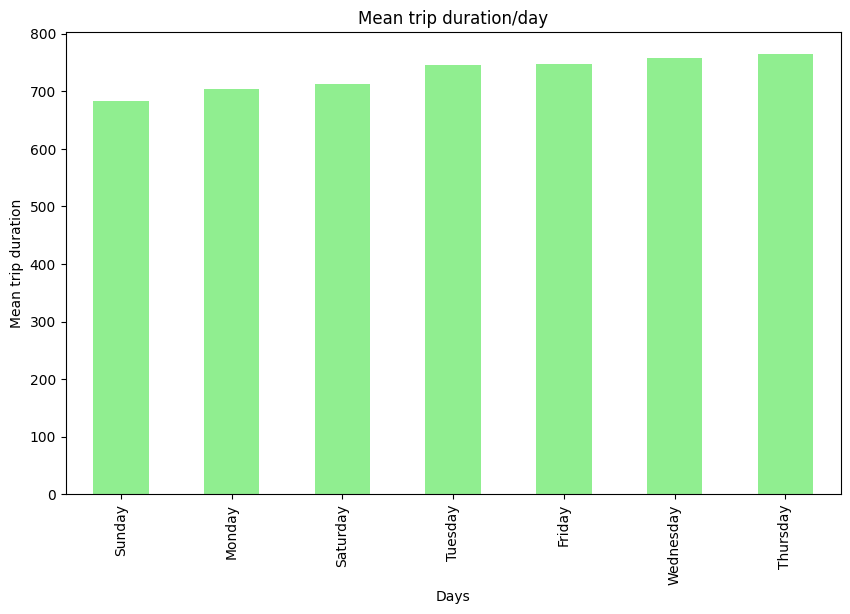

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

mean_duration = data.groupby('pickup_day')['trip_duration'].mean().sort_values()
mean_duration.plot(kind='bar', ax=ax, color='lightgreen')

ax.set_title('Mean trip duration/day')
ax.set_xlabel('Days')
ax.set_ylabel('Mean trip duration')
plt.show()

I thought that weekend will dominates the mean trip_duration. but actually it don't!

We want to see the statistical significance of this feature

In [10]:
aov = pg.anova(data=data, dv='trip_duration', between='pickup_day', detailed=True)
print(aov.columns)
print(aov[['Source', 'F', 'p-unc', 'np2']])

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
       Source           F  p-unc       np2
0  pickup_day  906.537326    0.0  0.003914
1      Within         NaN    NaN       NaN


We can see that p-value < 0.05 so it means that thats feature is significance

Then, let see if hour is significance to change the trip_duration

In [11]:
data["pickup_hour"] =  data["pickup_datetime"].dt.hour
aov = pg.anova(data=data, dv='trip_duration', between='pickup_hour', detailed=True)
print(aov[['Source', 'F', 'p-unc', 'np2']])

        Source           F  p-unc       np2
0  pickup_hour  433.709342    0.0  0.007154
1       Within         NaN    NaN       NaN


We want to see the difference of different time section

In [12]:
def categorize_hour(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 19:
        return 'Rush Hour'
    elif 10 <= hour <= 15:
        return 'Midday'
    elif 20 <= hour <= 23:
        return 'Night'
    else:
        return 'Early Morning'

In [13]:
data['hour_category'] = data['pickup_hour'].apply(categorize_hour)

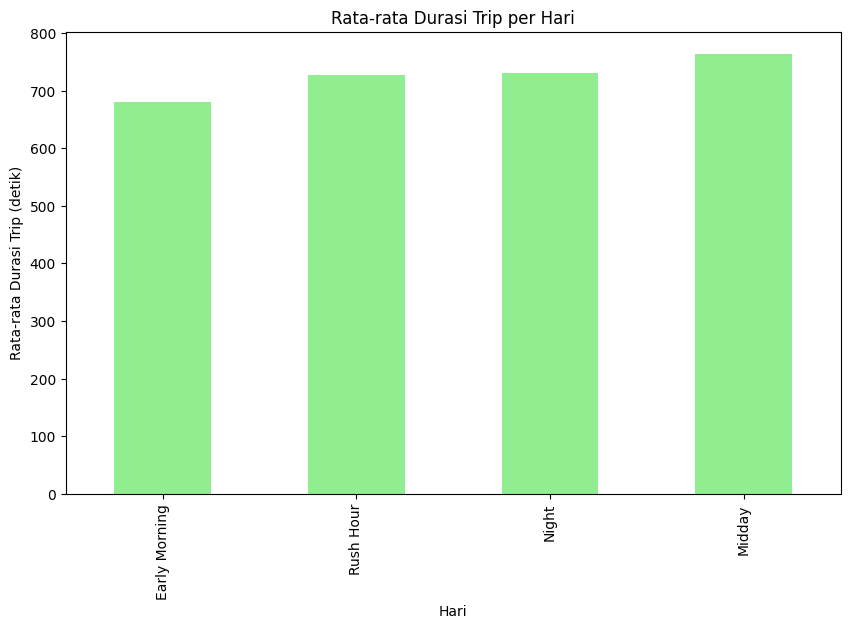

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

mean_duration = data.groupby('hour_category')['trip_duration'].mean().sort_values()
mean_duration.plot(kind='bar', ax=ax, color='lightgreen')

ax.set_title('Rata-rata Durasi Trip per Hari')
ax.set_xlabel('Hari')
ax.set_ylabel('Rata-rata Durasi Trip (detik)')
plt.show()

In [15]:
aov = pg.anova(data=data, dv='trip_duration', between='hour_category', detailed=True)
print(aov[['Source', 'F', 'p-unc', 'np2']])

          Source            F  p-unc       np2
0  hour_category  1598.966291    0.0  0.003453
1         Within          NaN    NaN       NaN


That's statistical significance too, so we include that to our feature

we want to see haversine distance (km).

for more information about haversine [[haversine](https://en.wikipedia.org/wiki/Haversine_formula)]

In [16]:
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371  

    # Konversi ke radian
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Selisih koordinat
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Rumus Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


In [17]:
data['haversine_distance'] = haversine_np(
    data['pickup_latitude'],
    data['pickup_longitude'],
    data['dropoff_latitude'],
    data['dropoff_longitude']
)


Remove haversine outliers

In [18]:
Q1 = data['haversine_distance'].quantile(0.25)
Q3 = data['haversine_distance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['haversine_distance'] >= lower_bound) & (data['haversine_distance'] <= upper_bound)]

{'whiskers': [<matplotlib.lines.Line2D at 0x22e26fc2b10>,
 'caps': [<matplotlib.lines.Line2D at 0x22e26fb0e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x22e26fc93d0>],
 'medians': [<matplotlib.lines.Line2D at 0x22e26fa11d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22e26f994d0>],
 'means': []}

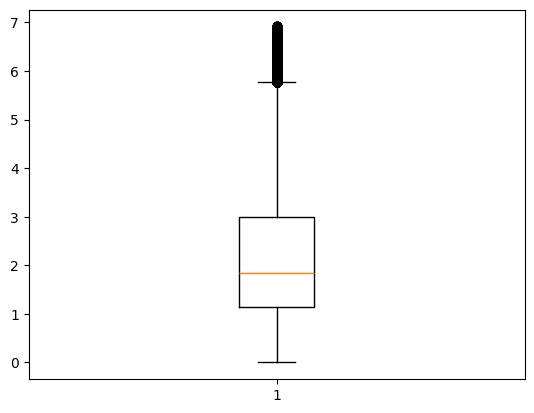

In [19]:
plt.boxplot(data["haversine_distance"])

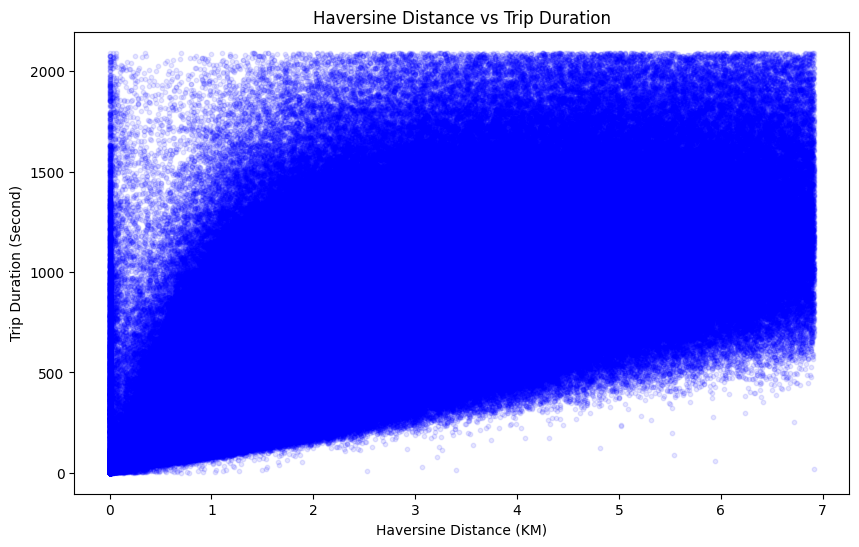

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data["haversine_distance"], y=data["trip_duration"], color='blue',  alpha=0.1, s=10)
ax.set_xlabel("Haversine Distance (KM)")
ax.set_ylabel("Trip Duration (Second)")
ax.set_title("Haversine Distance vs Trip Duration")
plt.show()

In [21]:
data["haversine_distance"].corr(data["trip_duration"])

np.float64(0.6809306073066248)

That's a high correlation

Let's see difference of trip_duration mean between two vendor 

<Axes: ylabel='vendor_id'>

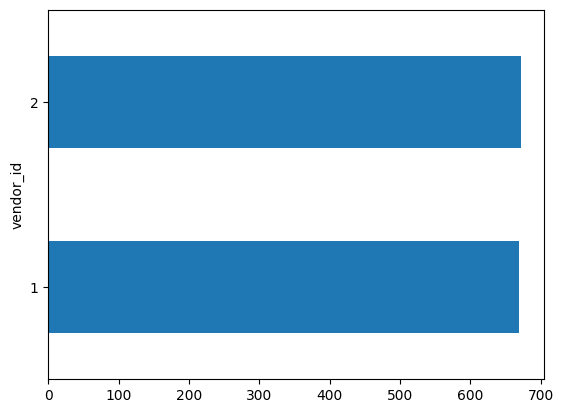

In [22]:
data.groupby("vendor_id")["trip_duration"].mean().plot(kind="barh")


Theres not much diffferences between two vendor_id .Hmmm ithink this feature will not be useful to predict the trip_duration

<Axes: xlabel='store_and_fwd_flag'>

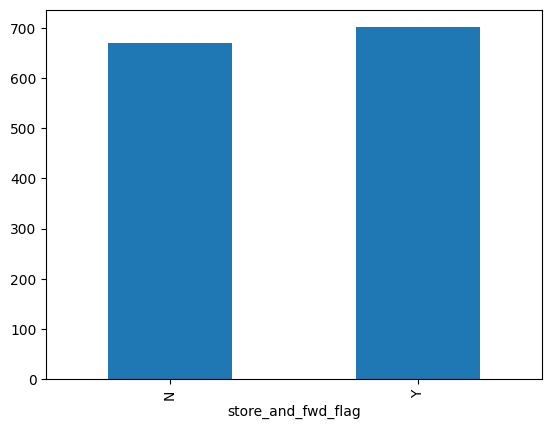

In [23]:
data.groupby("store_and_fwd_flag")["trip_duration"].mean().plot(kind="bar")

They have a slight difference. we could take this as a feature.

In [24]:
aov = pg.anova(data=data, dv='trip_duration', between='store_and_fwd_flag', detailed=True)
print(aov.columns)
print(aov[['Source', 'F', 'p-unc', 'np2']])

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
               Source          F         p-unc       np2
0  store_and_fwd_flag  36.595185  1.454306e-09  0.000029
1              Within        NaN           NaN       NaN


Lets add new feature (manhattan_distance) and how its correlation to trip duration

In [25]:
def manhattan_distance_km(lat1, lon1, lat2, lon2):
    R = 6371  # radius Bumi dalam km
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    lon1, lon2 = np.radians(lon1), np.radians(lon2)

    dlat_km = np.abs(lat2 - lat1) * R
    dlon_km = np.abs(lon2 - lon1) * R * np.cos((lat1 + lat2)/2) 

    return dlat_km + dlon_km

In [26]:
data['manhattan_distance'] = manhattan_distance_km(
    data['pickup_latitude'],
    data['pickup_longitude'],
    data['dropoff_latitude'],
    data['dropoff_longitude']
)

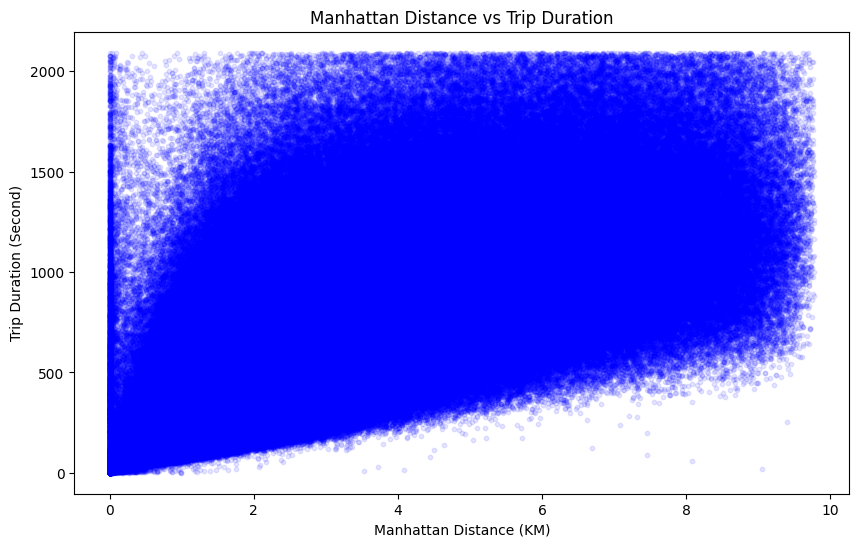

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data["manhattan_distance"], y=data["trip_duration"], color='blue',  alpha=0.1, s=10)
ax.set_xlabel("Manhattan Distance (KM)")
ax.set_ylabel("Trip Duration (Second)")
ax.set_title("Manhattan Distance vs Trip Duration")
plt.show()

In [28]:
data["manhattan_distance"].corr(data["trip_duration"])

np.float64(0.6646457395965271)

Since we using random forrest regression we dont neet one hot encoding 

Drop column that dont need

In [29]:
drop_columns = ['id','vendor_id','pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
data.drop(drop_columns, axis = 1, inplace= True)


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1276675 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1276675 non-null  int64  
 1   store_and_fwd_flag  1276675 non-null  object 
 2   trip_duration       1276675 non-null  int64  
 3   pickup_day          1276675 non-null  object 
 4   pickup_hour         1276675 non-null  int32  
 5   hour_category       1276675 non-null  object 
 6   haversine_distance  1276675 non-null  float64
 7   manhattan_distance  1276675 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(3)
memory usage: 82.8+ MB


In [31]:
X = data.drop("trip_duration", axis=1)
y = data["trip_duration"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
cat_cols = data.select_dtypes(include="object").columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
X_valid[cat_cols] = oe.transform(X_valid[cat_cols])

In [33]:
param_grid = {
    'max_depth': [1, 3 , 5, 7 , 9 ,11 ,13, 15],
}


In [34]:
result = []
for i in param_grid["max_depth"]: 
    rf = RandomForestRegressor(random_state=42 , max_depth=i)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)
    mae_scores = mean_absolute_error(y_pred, y_valid)
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    result.append({
        "max_depth" : i,
        "mae" : mae_scores,
        "rmsle" :rmsle
    })

KeyboardInterrupt: 

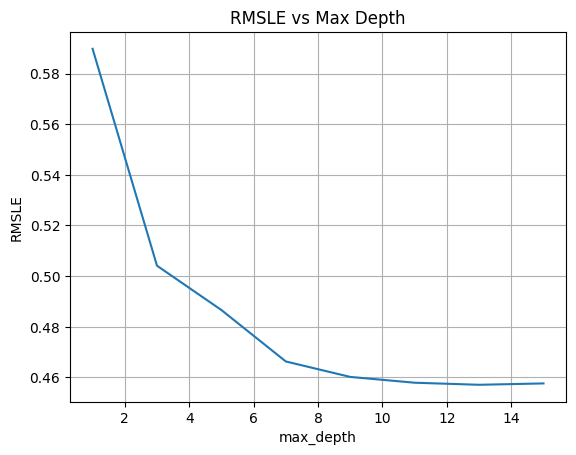

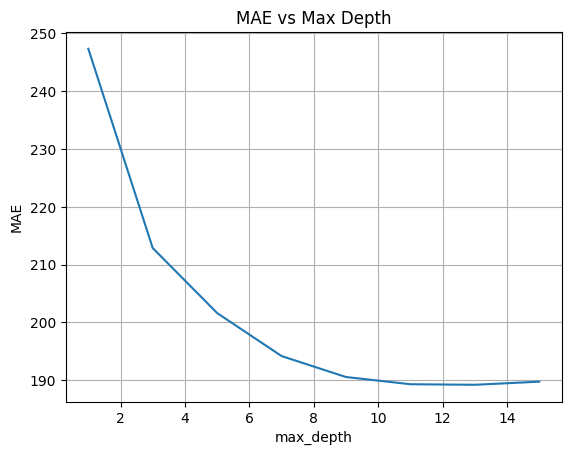

In [ ]:
df_result = pd.DataFrame(result)
df_result.plot(x="max_depth", y="rmsle", title="RMSLE vs Max Depth", legend=False)
plt.ylabel("RMSLE")
plt.grid(True)
plt.show()

df_result.plot(x="max_depth", y="mae", title="MAE vs Max Depth", legend=False)
plt.ylabel("MAE")
plt.grid(True)
plt.show()


In [41]:
rf = RandomForestRegressor(random_state=42 , max_depth=9)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, random_state=42)

Using elbow method we choose the max_depth of 9

In [ ]:
def wrangle_data(data):
    #remove uncommon data
    data = data[(data['passenger_count'] <= 6) & (data['passenger_count'] > 0)]
    id_pessenger = data["id"]

    #add pickup_day 
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['pickup_day'] = data['pickup_datetime'].dt.day_name()
    #add pickup hour
    data["pickup_hour"] =  data["pickup_datetime"].dt.hour
    #add hour category
    data['hour_category'] = data['pickup_hour'].apply(categorize_hour)
    data['haversine_distance'] = haversine_np(
        data['pickup_latitude'],
        data['pickup_longitude'],
        data['dropoff_latitude'],
        data['dropoff_longitude']
    )
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data['haversine_distance'] >= lower_bound) & (data['haversine_distance'] <= upper_bound)]
    #save id 
    id_pessenger = data["id"]
    data['manhattan_distance'] = manhattan_distance_km(
        data['pickup_latitude'],
        data['pickup_longitude'],
        data['dropoff_latitude'],
        data['dropoff_longitude']
    )
    #drop useless columns
    drop_columns = ['id','vendor_id','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
    data.drop(drop_columns, axis = 1, inplace= True)
    #encode columns
    cat_cols = data.select_dtypes(include="object").columns.tolist()
    data[cat_cols] = oe.transform(data[cat_cols])

    return data , id_pessenger
    

In [55]:
test_data = pd.read_csv("test.csv")
print(len(test_data))
X_test, id_test = wrangle_data(test_data)

# Predict
y_pred = rf.predict(X_test)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': id_test,
    'trip_duration': y_pred
})


625134


C:\Users\rasyi\AppData\Local\Temp\ipykernel_17404\102346091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
C:\Users\rasyi\AppData\Local\Temp\ipykernel_17404\102346091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pickup_day'] = data['pickup_datetime'].dt.day_name()
C:\Users\rasyi\AppData\Local\Temp\ipykernel_17404\102346091.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [56]:
submission_df.to_csv("sample_submission.csv", index=False)